<a href="https://colab.research.google.com/github/uccaoeo/Kaggle-Learning/blob/main/Spam_Detection_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [2]:
!pip install -q wordcloud


**Spam detection** :

1. Read dataset and make it in proper format. 

2. Encode labels

3. Convert all cases to lower

4. Remove punctuations

5. Remove Stopwords

6. Convert all texts into vectors

7. Import classifier

8. Train and test split

9. Check the accuracy/confusion matrix and classification report.



In [3]:

import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/priyalagarwal27/E-mail-spam-detection/main/messages.csv',encoding='latin-1')

In [6]:
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [8]:
#Checking the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2893, 3)


In [10]:
#Checking for the null values
df.isnull().values.any()

True

In [9]:

#Checkin for the null values in columns
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

Observations:

1. 62 row are missing in the subject columns that means 62 emails are without subject heading. 
2. Here, not dropping Nan rows for subject column as it of no use in building model.

In [11]:
#Checking total number of mails
print("Count of label:\n",df['label'].value_counts())

Count of label:
 0    2412
1     481
Name: label, dtype: int64


NOTE- In our sample dataset, 0 stands for not spam while 1 represent Spam





In [12]:
#Checking the Ratio of labels
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 83.0 %
Spam Email Ratio that is 1 label: 17.0 %


In [14]:
#Creating the new column for length of message column
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [15]:
#Converting all messages to lower case
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [16]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
   
# Replace numeric characters with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [17]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [18]:
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [20]:
#Removing the stopwords
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [21]:
# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.message.str.len()
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2179
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1454
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0,1435,1064
3,risk,colleague researching differing degrees risk p...,0,324,210
4,request book information,earlier morning phone friend mine living south...,0,1046,629


In [22]:
#Total length removal
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 9344743
Cleaned Length: 6767857
Total Words Removed: 2576886


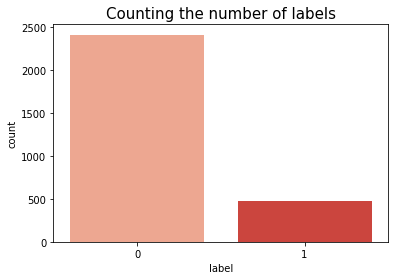

0    2412
1     481
Name: label, dtype: int64


In [23]:
#Graphical Visualisation for counting number of labels.
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(df.label.value_counts())

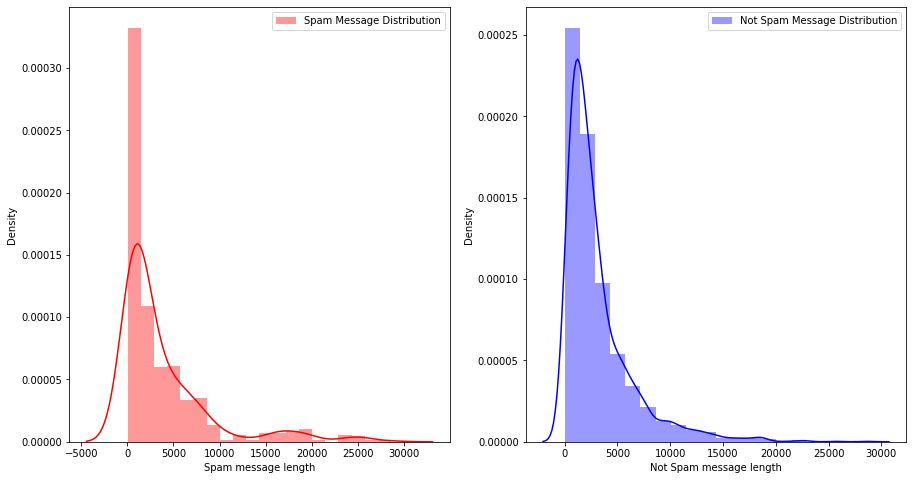

In [24]:
#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

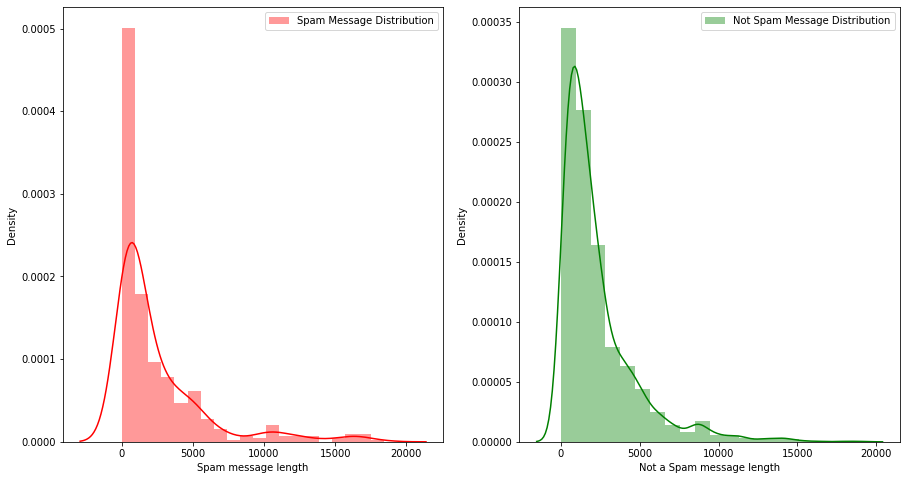

In [25]:
#Message distribution after cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

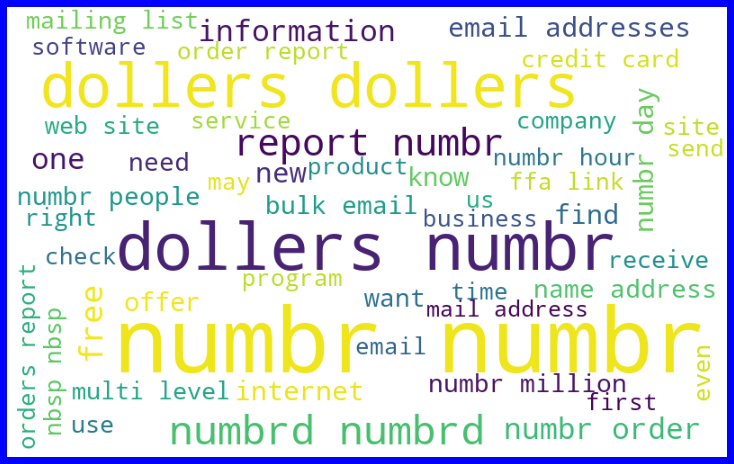

In [26]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

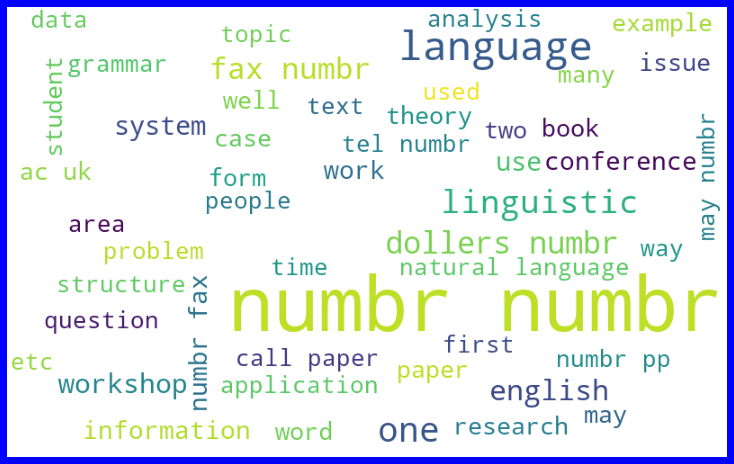

In [27]:
#Getting sense of loud words in not-spam 
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [33]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label


tf_vec = TfidfVectorizer()

naive = MultinomialNB()

#SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [35]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)         #test_size=0.20 random_state=42 test_size=0.15

naive.fit(X_train,Y_train)
y_pred= naive.predict(x_test)

#SVM.fit(X_train,Y_train)
#y_pred = SVM.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8342541436464088


In [36]:
y_pred


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
# Checking Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       585
           1       1.00      0.14      0.24       139

    accuracy                           0.83       724
   macro avg       0.91      0.57      0.57       724
weighted avg       0.86      0.83      0.78       724



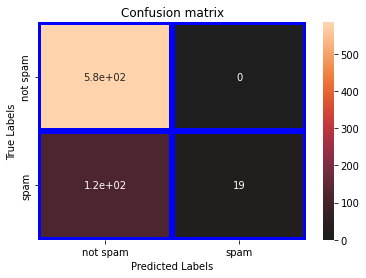

In [38]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

#### SVM performs better than naive_bayes..Naive Bayes accuracy score was 83-88% while SVM was 98%

##Saving our SVM Model


In [39]:
#We see SVM to perform the best.
#save the best model.
import pickle
filename='Email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()